# Variantes de LMS

Procesamiento Adaptativo de Señales Aleatorias

© Marc S. Ressl

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

## NLMS

En este ejemplo comparamos el comportamiento de un filtro adaptativo LMS con la variante NLMS.

Aplicamos ambos algoritmos a un problema de predicción. Estimaremos el coeficiente $a$ de un modelo autorregresivo de orden uno a través de un predictor de orden uno. Cuando el predictor converge, su coeficiente $w$ tenderá a $-a$.

En este ejemplo el parámetro $a$ del modelo de señal oscila periódicamente entre -0.99 y -0.099 cada 1000 muestras.

### Modelo IIR

In [2]:
# Parámetros del modelo IIR
sigma2v = 0.0186264
a1 = -0.99
a2 = -0.099
a_period = 1000

def get_model_output(N):
    '''
    Calcula la salida de un sistema autorregresivo de orden uno
    '''
    # N_IIR es un margen que evita que el modelo de señal IIR tenga dependencias temporales
    N_IIR = 1000
    
    v = np.random.normal(0, np.sqrt(sigma2v), size=(N_IIR + N))
    x = np.zeros((len(v), 1))
    for n in range(1, len(v)):
        if (int(n / a_period) % 2) == 0:
            a_eff = a1
        else:
            a_eff = a2
        x[n] = -a_eff * x[n - 1] + v[n - 1]
    
    return x[N_IIR:]

Un ejemplo de una realización del modelo:

In [3]:
N = 10000

x = get_model_output(N)

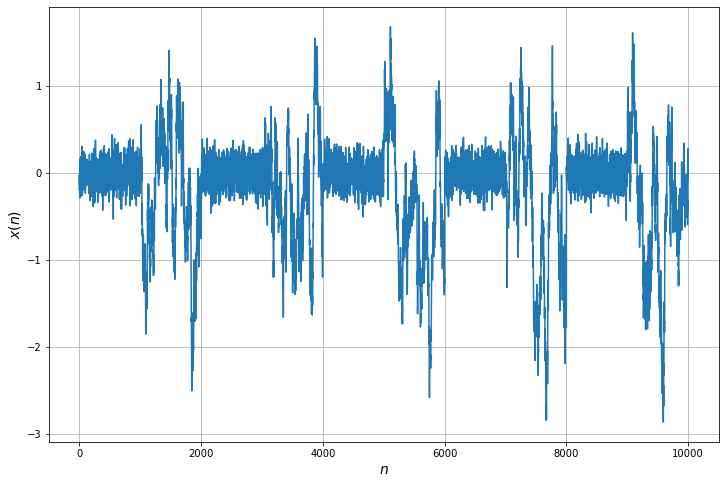

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(x)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$x(n)$', fontsize=14)
plt.grid(True)
plt.show()

Este sistema es un buen candidato para el algoritmo NLMS ya que presenta potencia variable.

### Implementación

In [5]:
def calc_lms_montecarlo(K, w0, mu, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo LMS
    aplicado a un problema de predicción lineal de orden uno.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu: parámetro de paso
    N: número de iteraciones
    """
    
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, 1))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        x = get_model_output(N)
        
        # Predicción LMS
        w = np.zeros((N, 1))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            y_hat = w[n - 1] * x[n - 1]             # Ecuación de filtrado
            y = x[n]
            e = y - y_hat
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * x[n - 1] * e     # Ecuación LMS

        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [6]:
def calc_nlms_montecarlo(K, w0, mu_tilde, delta, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo NLMS
    aplicado a un problema de predicción lineal de orden uno.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu_tilde: parámetro de paso normalizado
    delta: parámetro de seguridad para la estimación de energía
    N: número de iteraciones
    """
    
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, 1))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        x = get_model_output(N)
        
        # Predicción NLMS
        w = np.zeros((N, 1))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            y_hat = w[n - 1] * x[n - 1]                                      # Ecuación de filtrado
            y = x[n]
            e = y - y_hat
            J[n - 1] = e * e
            x_energy = x[n - 1] * x[n - 1]
            w[n] = w[n - 1] + mu_tilde / (x_energy + delta) * x[n - 1] * e     # Ecuación NLMS
            
        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [7]:
w0 =0
mu = 0.08
mu_tilde = 0.04
delta = 0.01
N = 10000

### Convergencia de una realización

In [8]:
K = 1

w_lms, J_lms = calc_lms_montecarlo(K, w0, mu, N)
w_nlms, J_nlms = calc_nlms_montecarlo(K, w0, mu_tilde, delta, N)

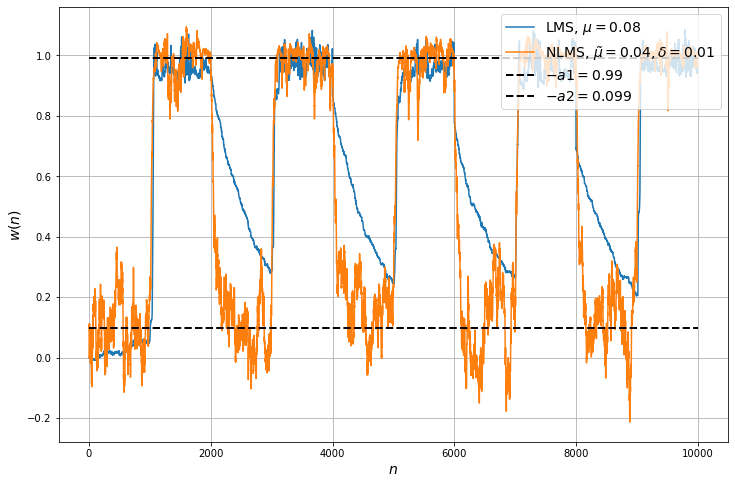

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(w_lms, label='LMS, $\mu=%s$' % mu)
plt.plot(w_nlms, label='NLMS, $\mathit{µ̃}=%s, \delta=%s$' % (mu_tilde, delta))
plt.plot([0, len(w_lms) - 1], [-a1, -a1], color='k', linestyle='--', linewidth=2, label='$-a1=%s$' % -a1)
plt.plot([0, len(w_lms) - 1], [-a2, -a2], color='k', linestyle='--', linewidth=2, label='$-a2=%s$' % -a2)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$w(n)$', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=14)
plt.show()

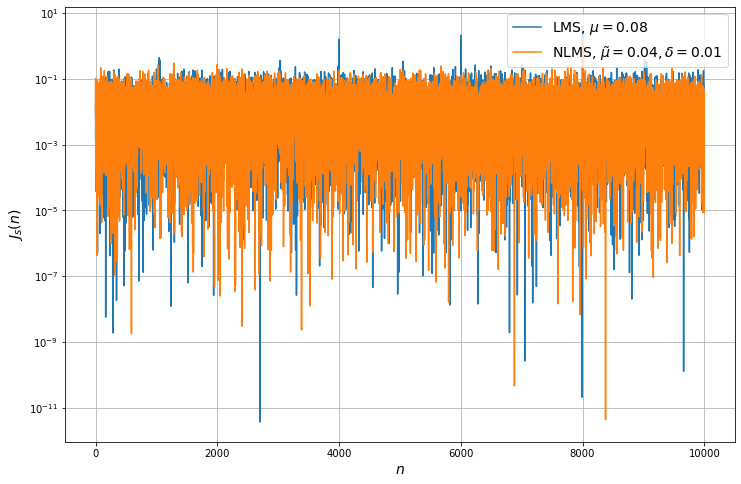

In [10]:
plt.figure(figsize=(12, 8))
plt.semilogy(J_lms, label='LMS, $\mu=%s$' % mu)
plt.semilogy(J_nlms, label='NLMS, $\mathit{µ̃}=%s, \delta=%s$' % (mu_tilde, delta))
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$J_s(n)$', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=14)
plt.show()

### Convergencia media con simulación de Monte Carlo

¡Cuidado! Debido a que se calculan 10000 realizaciones para cada simulación, el siguiente paso tarda varios minutos. Es posible disminuir el valor de $K$ para obtener una estimación más rápida, pero más ruidosa.

In [11]:
K = 10000

w_lms_mc, J_lms_mc = calc_lms_montecarlo(K, w0, mu, N)
w_nlms_mc, J_nlms_mc = calc_nlms_montecarlo(K, w0, mu_tilde, delta, N)

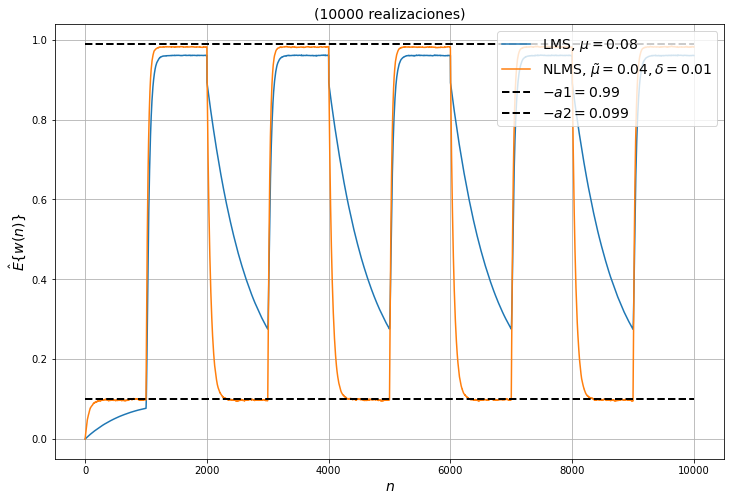

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(w_lms_mc, label='LMS, $\mu=%s$' % mu)
plt.plot(w_nlms_mc, label='NLMS, $\mathit{µ̃}=%s, \delta=%s$' % (mu_tilde, delta))
plt.plot([0, len(w_lms) - 1], [-a1, -a1], color='k', linestyle='--', linewidth=2, label='$-a1=%s$' % -a1)
plt.plot([0, len(w_lms) - 1], [-a2, -a2], color='k', linestyle='--', linewidth=2, label='$-a2=%s$' % -a2)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w(n)\}$', fontsize=14)
plt.grid(True)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* En LMS se observa la dependencia de la velocidad de convergencia con la energía de la señal.
* La velocidad de convergencia en NLMS es relativamente independiente de la energía.
* NLMS converge mejor al valor verdadero $-a$.

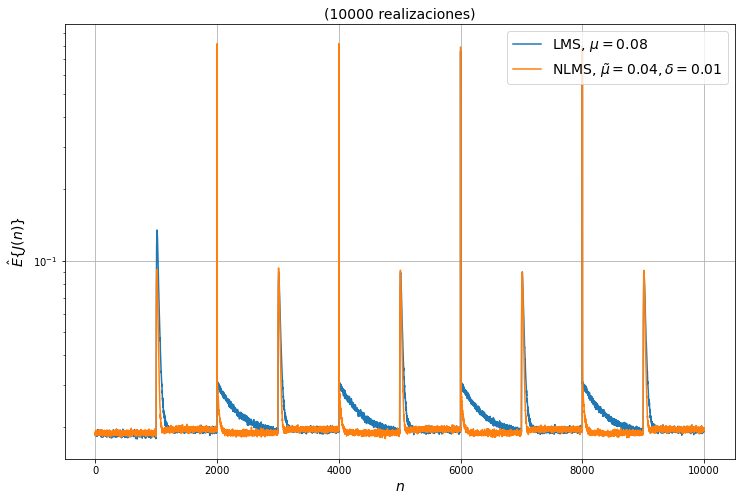

In [13]:
plt.figure(figsize=(12, 8))
plt.semilogy(J_lms_mc, label='LMS, $\mu=%s$' % mu)
plt.semilogy(J_nlms_mc, label='NLMS, $\mathit{µ̃}=%s, \delta=%s$' % (mu_tilde, delta))
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{J(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* El desajuste en LMS depende del nivel de energía.
* El desajuste en NLMS es relativamente independiente del nivel de energía.
* Se observan los transitorios debidos al cambio de $a$.

Comentarios finales:

* NLMS puede lograr mejor performance que LMS.
* NLMS tiene dos metaparámetros, $\tilde{\mu}$ y $\delta$, que deben ser ajustados. Su puesta en marcha puede presentar, por tanto, mayores dificultades que LMS.

## VS-LMS

En este ejemplo comparamos el comportamiento de un filtro adaptativo LMS con la variante VS-LMS.

Aplicamos ambos algoritmos a un problema de identificación de sistemas. Estimaremos los coeficientes $\mathbf{h}$ de un sistema moving-average de orden cinco a través de un filtro adaptativo de orden cinco.

La entrada al sistema es la señal $\mathbf{x}$. La salida $y$ del sistema es una versión filtrada de la señal de entrada $\mathbf{x}$, más ruido blanco de energía $v$.

### Modelo moving-average

In [14]:
# Parámetros del modelo
sigma2x = 1                         # Energía de la señal de entrada al sistema
sigma2v = 0.001                     # Energía del ruido añadido por el sistema
h = [0.93, 0.17, 0.49, 1.15, 0.21]  # Coeficientes del filtro moving-average del sistema
M = len(h)

In [15]:
def get_model_input(N):
    '''
    Calcula la señal de entrada al sistema
    '''
    return np.random.normal(0, np.sqrt(sigma2x), size=N)

def get_model_output(x):
    '''
    Calcula la salida del sistema
    '''
    x_filtered = signal.lfilter(h, [1], x)
    v = np.random.normal(0, np.sqrt(sigma2v), size=len(x))

    return x_filtered + v

### Implementación

In [16]:
def calc_lms_montecarlo(K, w0, mu, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo LMS
    aplicado a un problema de identificación de sistemas de orden cinco.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu: parámetro de paso
    N: número de iteraciones
    """
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        x = get_model_input(N + M - 1)
        y = get_model_output(x)
        
        # Identifcación de sistemas LMS
        w = np.zeros((N, M))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            x_flipped = np.flipud(x[n:n + M])
            y_hat = np.dot(x_flipped, w[n - 1])         # Ecuación de filtrado
            e = y[n + M - 1] - y_hat
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * x_flipped * e    # Ecuación LMS

        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [17]:
def calc_vslms_montecarlo(K, w0, alpha, mu_min, mu_max, m0, m1, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo VS-LMS
    aplicado a un problema de identificación de sistemas de orden cinco.

    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    alpha: constante de ajuste de mu variable
    mu_min: valor mínimo de mu
    mu_max: valor máximo de mu
    m0: número de veces que los últimos signos cambiaron para disminuir mu
    m1: número de veces que los últimos signos se conservaron para aumentar mu
    N: número de iteraciones
    """

    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    mu_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))

    for i in range(K):
        x = get_model_input(N + M - 1)
        y = get_model_output(x)

        # Identificación de sistemas VS-LMS
        w = np.zeros((N, M))
        mu = np.ones((N, M)) * mu_max
        J = np.zeros((N, 1))
        last_sign = np.full(M, True, dtype=bool)                        # Memoria de los signos anteriores
        sign_change = np.zeros((max(m0, m1), M))                        # Memoria de cambio de signo
        w[0] = w0

        for n in range(1, N):
            x_flipped = np.flipud(x[n:n + M])
            y_hat = np.dot(x_flipped, w[n - 1])                         # Ecuación de filtrado
            e = y[n + M - 1] - y_hat
            J[n - 1] = e * e

            half_gradient = -x_flipped * e
            current_mu = mu[n - 1]
            w[n] = w[n - 1] - np.multiply(current_mu, half_gradient)    # Ecuación VS-LMS

            # Update VS-LMS
            current_sign = (half_gradient >= 0)
            sign_change = np.roll(sign_change, 1, axis=0)               # Actualiza la memoria de cambio de signo
            sign_change[0] = np.where(np.logical_xor(current_sign, last_sign), 1.0, 0.0)
            last_sign = current_sign

            # Divide por alpha si los últimos m0 signos alternaron
            current_mu /= np.where(np.sum(sign_change[0:m0], axis=0) == m0, alpha, 1.0)
            # Multiplica por alpha si los últimos m1 signos se conservaron
            current_mu *= np.where(np.sum(sign_change[0:m1], axis=0) == 0, alpha, 1.0)
            # Acota los valores de mu a mu_min y mu_max
            mu[n] = np.clip(current_mu, mu_min, mu_max)

        J[N - 1] = J[N - 2]

        w_montecarlo += w
        mu_montecarlo += mu
        J_montecarlo += J

    w_montecarlo /= K
    mu_montecarlo /= K
    J_montecarlo /= K

    return (w_montecarlo, mu_montecarlo, J_montecarlo)

In [18]:
w0 = np.zeros(M)
mu = 0.05
alpha = 1.05
mu_min = 0.001
mu_max = 0.15
m0 = 1
m1 = 2
N = 200

### Convergencia de una realización

In [19]:
K = 1

w_lms, J_lms = calc_lms_montecarlo(K, w0, mu, N)
w_vslms, mu_vslms, J_vslms = calc_vslms_montecarlo(K, w0, alpha, mu_min, mu_max, m0, m1, N)

In [20]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

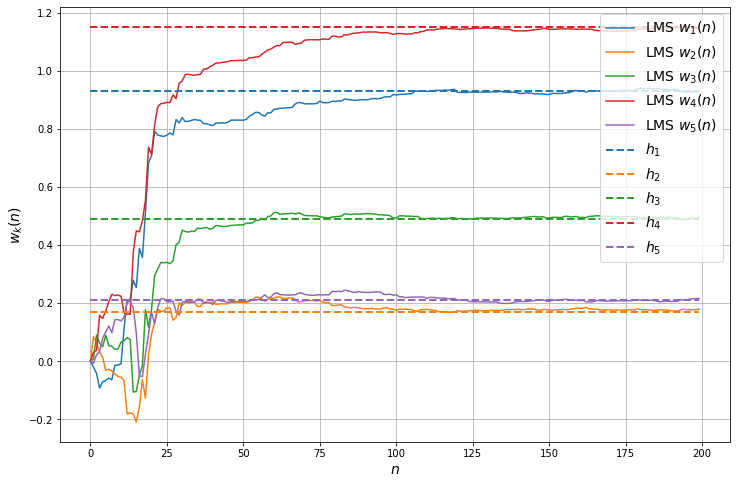

In [21]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_lms[:, i], label='LMS $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_lms) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$w_k(n)$', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=14)
plt.show()

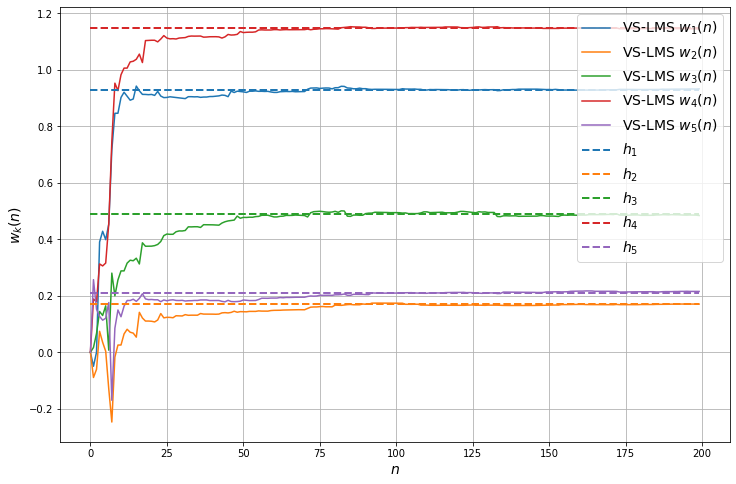

In [22]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_vslms[:, i], label='VS-LMS $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_vslms) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$w_k(n)$', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=14)
plt.show()

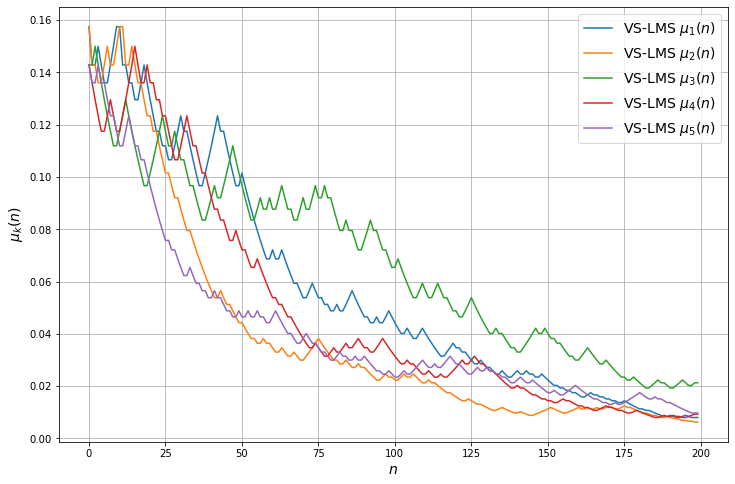

In [23]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(mu_vslms[:, i], label='VS-LMS $µ_%s(n)$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$µ_k(n)$', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* La velocidad de convergencia máxima de LMS y VS-LMS es la misma.
* VS-LMS puede, sin embargo, alcanzar menor desajuste cuando el sistema está en condiciones de convergencia.
* Los niveles $µ_k(n)$ son discretos.

### Convergencia media con simulación de Monte Carlo

¡Cuidado! Debido a que se calculan 10000 realizaciones para cada simulación, el siguiente paso tarda varios minutos. Es posible disminuir el valor de K para obtener una estimación más rápida, pero más ruidosa.

In [24]:
K = 10000

w_lms_mc, J_lms_mc = calc_lms_montecarlo(K, w0, mu, N)
w_vslms_mc, mu_vslms_mc, J_vslms_mc = calc_vslms_montecarlo(K, w0, alpha, mu_min, mu_max, m0, m1, N)

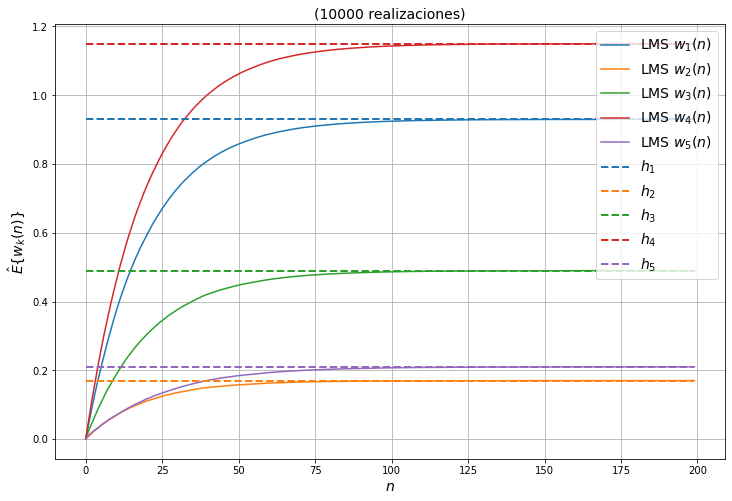

In [25]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_lms_mc[:, i], label='LMS $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_lms_mc) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

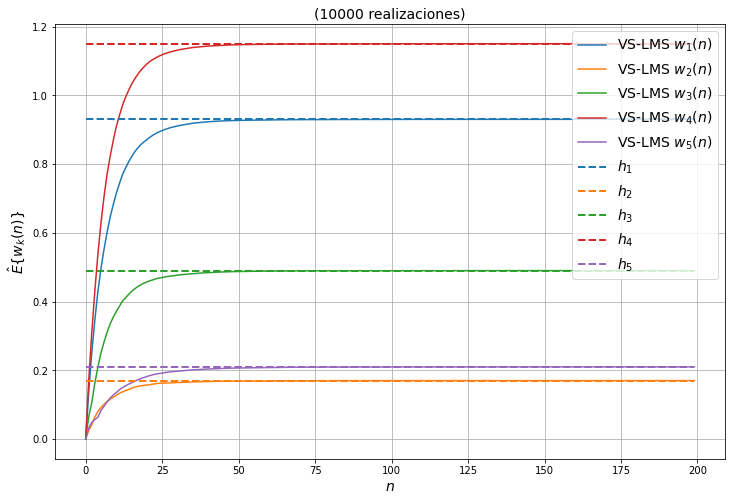

In [26]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_vslms_mc[:, i], label='VS-LMS $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_vslms_mc) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

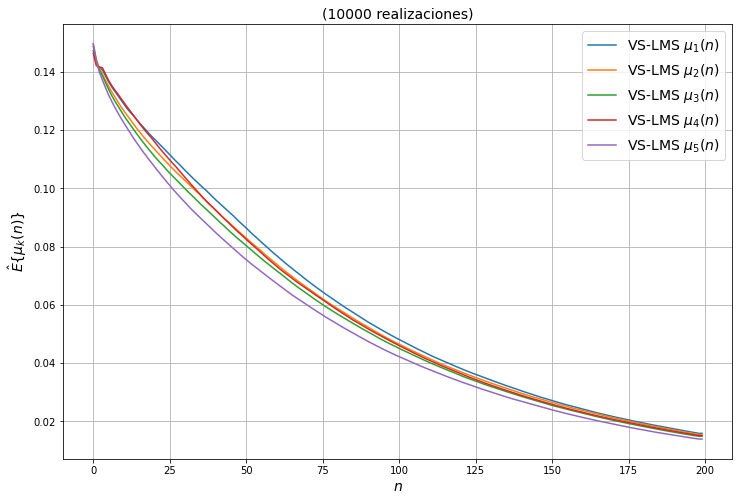

In [27]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(mu_vslms_mc[:, i], label='VS-LMS $µ_%s(n)$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{µ_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

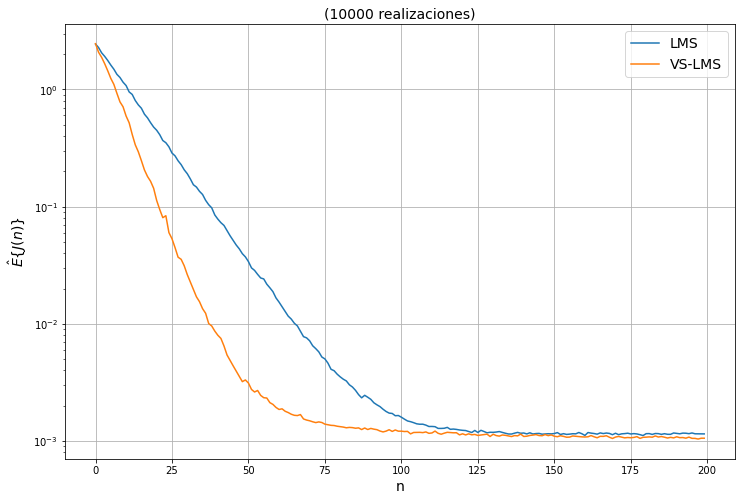

In [28]:
plt.figure(figsize=(12, 8))
plt.semilogy(J_lms_mc, label='LMS')
plt.semilogy(J_vslms_mc, label='VS-LMS')
plt.xlabel('n', fontsize=14)
plt.ylabel('$\hat{E}\{J(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* En la media, la evolución de los $\mu_k(n)$ es continua.
* VS-LMS da lo mejor de los dos mundos: alta velocidad de convergencia y bajo desajuste.

Comentarios finales:

* VS-LMS puede tener mejor performance que LMS.
* VS-LMS tiene cinco metaparámetros, $\alpha$, $\mu_\mathrm{min}$, $\mu_\mathrm{max}$, $m_0$ y $m_1$ que deben ser ajustados. Su puesta en marcha puede presentar, por tanto, mayores dificultades que LMS.

## Sign LMS

En este ejemplo comparamos el comportamiento de un filtro adaptativo LMS con las variantes sign-error, sign-data y sign-sign.

Para la comparacion usaremos el problema anterior de VS-LMS.

### Implementación

In [29]:
def calc_signerror_montecarlo(K, w0, mu, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo sign-error
    aplicado a un problema de identificación de sistemas de orden cinco.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu: parámetro de paso
    N: número de iteraciones
    """
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        x = get_model_input(N + M - 1)
        y = get_model_output(x)
        
        # Identificación de sistemas sign-error
        w = np.zeros((N, M))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            x_flipped = np.flipud(x[n:n + M])
            y_hat = np.dot(x_flipped, w[n - 1])             # Ecuación de filtrado
            e = y[n + M - 1] - y_hat
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * x_flipped * np.sign(e)   # Ecuación LMS
        
        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [30]:
def calc_signdata_montecarlo(K, w0, mu, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo sign-data
    aplicado a un problema de identificación de sistemas de orden cinco.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu: parámetro de paso
    N: número de iteraciones
    """
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        x = get_model_input(N + M - 1)
        y = get_model_output(x)
        
        # Identificación de sistemas sign-data
        w = np.zeros((N, M))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            x_flipped = np.flipud(x[n:n + M])
            y_hat = np.dot(x_flipped, w[n - 1])             # Ecuación de filtrado
            e = y[n + M - 1] - y_hat
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * np.sign(x_flipped) * e   # Ecuación LMS
        
        J[N - 1] = J[N - 2]
                
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [31]:
def calc_signsign_montecarlo(K, w0, mu, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo sign-sign
    aplicado a un problema de identificación de sistemas de orden cinco.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu: parámetro de paso
    N: número de iteraciones
    """
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        x = get_model_input(N + M - 1)
        y = get_model_output(x)
        
        # Identificación de sistemas sign-sign
        w = np.zeros((N, M))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            x_flipped = np.flipud(x[n:n + M])
            y_hat = np.dot(x_flipped, w[n - 1])                     # Ecuación de filtrado
            e = y[n + M - 1] - y_hat
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * np.sign(x_flipped) * np.sign(e)  # Ecuación LMS
        
        J[N - 1] = J[N - 2]
                
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [32]:
mu = 0.05
N = 200
w0 = np.zeros(M)

### Convergencia media con simulación de Monte Carlo

¡Cuidado! Debido a que se calculan 10000 realizaciones para cada simulación, el siguiente paso tarda varios minutos. Es posible disminuir el valor de K para obtener una estimación más rápida, pero más ruidosa.

In [33]:
K = 10000

w_lms_mc, J_lms_mc = calc_lms_montecarlo(K, w0, mu, N)
w_signerror_mc, J_signerror_mc = calc_signerror_montecarlo(K, w0, mu, N)
w_signdata_mc, J_signdata_mc = calc_signdata_montecarlo(K, w0, mu, N)
w_signsign_mc, J_signsign_mc = calc_signsign_montecarlo(K, w0, mu, N)

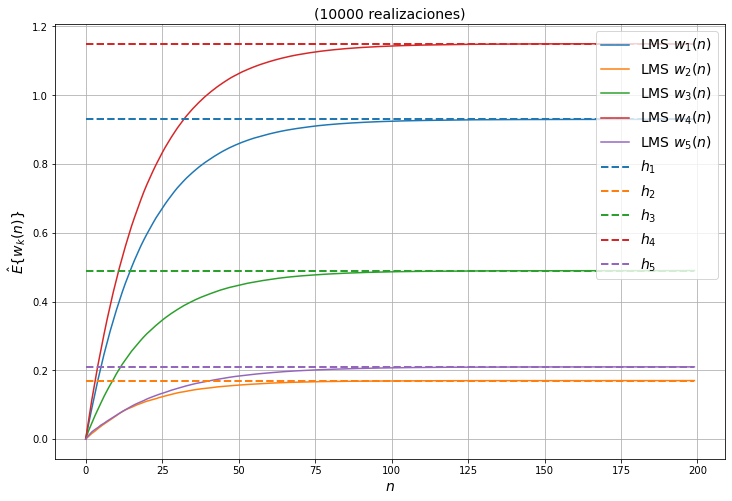

In [34]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_lms_mc[:, i], label='LMS $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_lms_mc) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

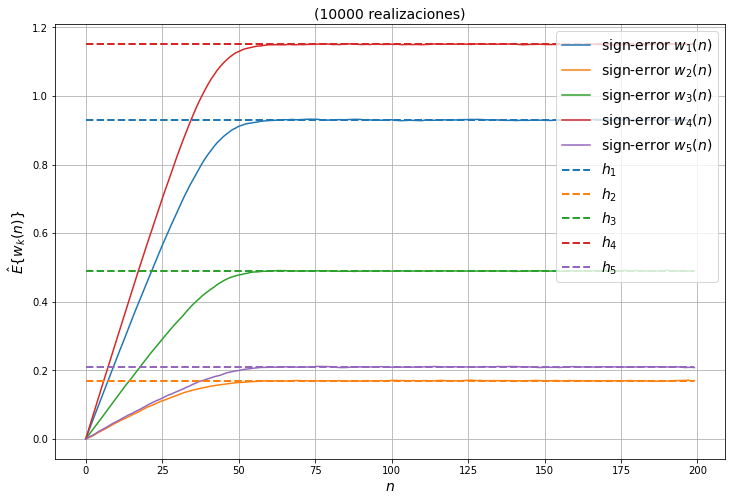

In [35]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_signerror_mc[:, i], label='sign-error $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_signerror_mc) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

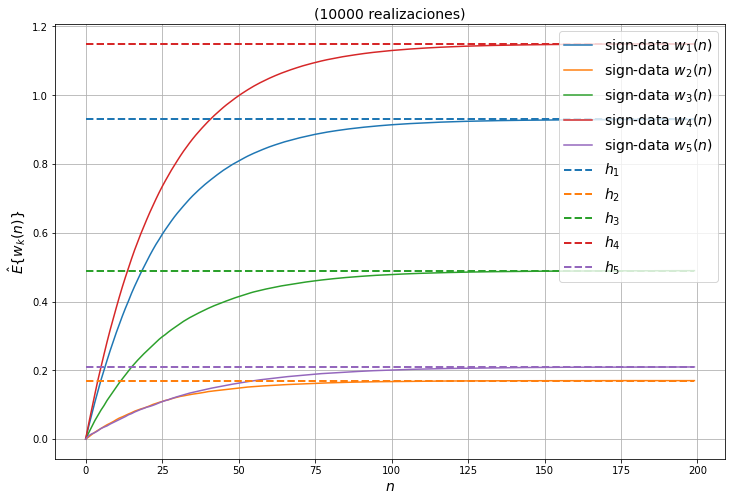

In [36]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_signdata_mc[:, i], label='sign-data $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_signdata_mc) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

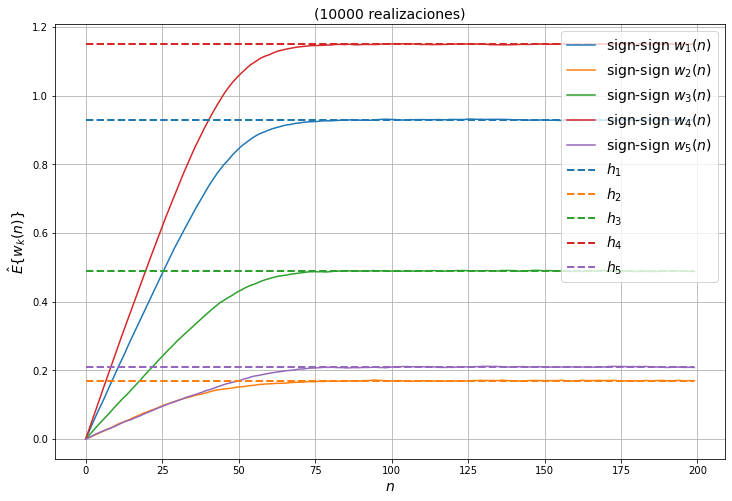

In [37]:
plt.figure(figsize=(12, 8))
for i in range(M):
    plt.plot(w_signsign_mc[:, i], label='sign-sign $w_%s(n)$' % (i + 1), color=colors[i])
for i in range(M):
    plt.plot([0, len(w_signsign_mc) - 1], [h[i], h[i]], linestyle='--', linewidth=2, label='$h_%s$' % (i + 1), color=colors[i])
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{w_k(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

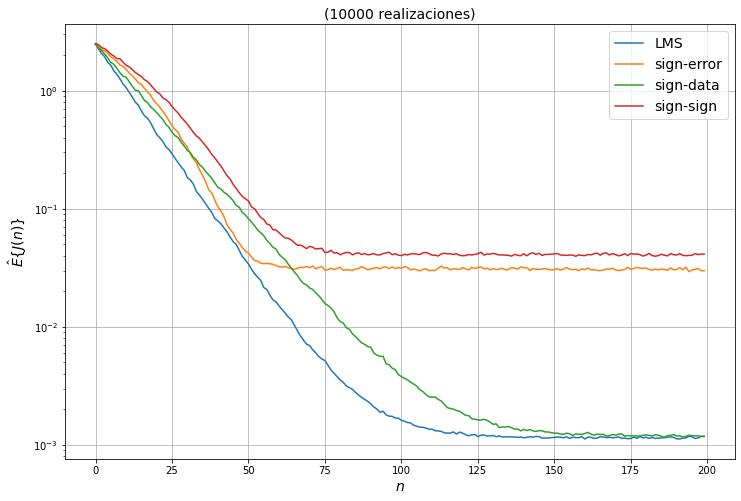

In [38]:
plt.figure(figsize=(12, 8))
plt.semilogy(J_lms_mc, label='LMS')
plt.semilogy(J_signerror_mc, label='sign-error')
plt.semilogy(J_signdata_mc, label='sign-data')
plt.semilogy(J_signsign_mc, label='sign-sign')
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\hat{E}\{J(n)\}$', fontsize=14)
plt.grid(True)
plt.title('(%s realizaciones)' % K, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* En la práctica, sign-error tiende a optimizar la velocidad de convergencia.
* En la práctica, sign-data tiende a optimizar el desajuste.